In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy as sp

from itertools import chain
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 14

In [3]:
MASS = 1.  # set particle mass to 1. for simplicity
T_SPAN = [0., 2.]  # how long to integrate for when computing particle trajectory

In [4]:
x, y = sp.symbols('x y', real=True)

pdf = sp.exp(-sp.Rational(1 / 2) * (x ** 2 + y ** 2)) / (2 * sp.pi)  # a simple symmetric 2D gaussian with identity covariance

In [5]:
potential_energy = -sp.log(pdf)  # define the potential energy as the negative log pdf
potential_energy.simplify()

x**2/2 + y**2/2 + log(2*pi)

In [6]:
px, py, m = sp.symbols('p_x p_y m', real=True)  # define momenta and mass symbols

M = m * sp.eye(2)  # mass matrix
p = sp.Matrix([px, py])  # momentum vector

In [7]:
kinetic_energy = sp.Rational(1 / 2) * p.transpose() * M.inv() * p  # T = p ** 2 / (2m)
kinetic_energy = kinetic_energy[0, 0]  # squeeze the scalar out of the matrix
kinetic_energy.simplify()

(p_x**2 + p_y**2)/(2*m)

In [8]:
H = potential_energy + kinetic_energy  # define the Hamiltonian
H.simplify()

(m*(x**2 + y**2 + 2*log(2) + 2*log(pi)) + p_x**2 + p_y**2)/(2*m)

In [9]:
state_vars = [[x, y], [px, py]]
signs = [1, 1, -1, -1]

dynamics = sp.Matrix(  # form rhs of hamiltons equations
        [
            (sign * H.diff(var)).simplify() for sign, var in zip(signs, chain(*reversed(state_vars)))
        ]   
)
dynamics 

Matrix([
[p_x/m],
[p_y/m],
[   -x],
[   -y]])

In [10]:
# sub for mass
dynamics = dynamics.subs(m, MASS)
M = M.subs(m, MASS)
H = H.subs(m, MASS)
sigma = np.diag(np.array(M, dtype=np.float64))

In [11]:
def gradient(func, syms):
    return sp.Matrix([func.diff(sym).simplify() for sym in syms])

In [12]:
force_field = -gradient(potential_energy, [x, y])
force_field

Matrix([
[-x],
[-y]])

In [13]:
pdf = sp.lambdify([x, y], pdf, 'numpy')

In [14]:
force_field = sp.lambdify([x, y], force_field, 'numpy')

In [15]:
dynamics = sp.lambdify(list(chain(*state_vars)), dynamics, 'numpy')

In [16]:
H = sp.lambdify(list(chain(*state_vars)), H, 'numpy')

In [17]:
def compute_dynamics(t, z):
    return dynamics(*z).squeeze()

Text(0.5, 1.0, '$\\mathcal{N}(\\mathbf{0}, \\mathbf{I})$')

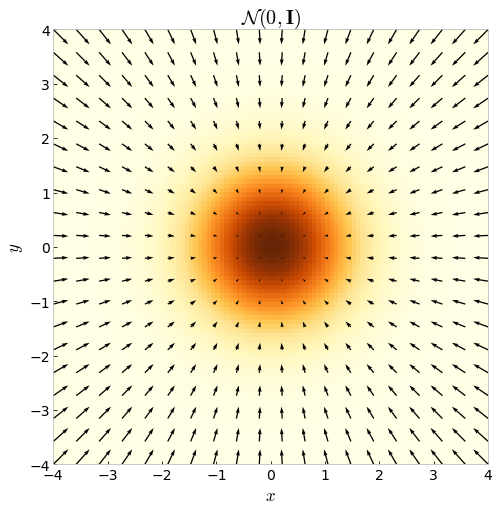

In [18]:
X_cont, Y_cont = np.mgrid[-4:4:100j, -4:4:100j]
X_quiv, Y_quiv = np.mgrid[-4:4:20j, -4:4:20j]

Fx, Fy = force_field(X_quiv, Y_quiv).squeeze()

fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(X_cont, Y_cont, pdf(X_cont, Y_cont), cmap='YlOrBr')
ax.quiver(X_quiv, Y_quiv, Fx, Fy, label='force')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_title('$\\mathcal{N}(\\mathbf{0}, \\mathbf{I})$')

In [19]:
def hmc(initial_position, num_samples=100):
    trajectories = []
    samples = []
    x0 = initial_position
    pbar = tqdm(total=num_samples, desc='HMC sampler')
    while len(samples) < num_samples:
        p0 = np.random.normal(size=len(p), scale=sigma)
        initial_state = np.concatenate([x0, p0])
        sol = solve_ivp(
            fun=compute_dynamics,
            y0=initial_state,
            t_span=T_SPAN,
            method='RK45',
            max_step=0.1,
        )
        trajectory = sol.y
        final_state = trajectory[:, -1]
        initial_energy = H(*initial_state)
        final_energy = H(*final_state)
        l_ratio = min([1., np.exp(-final_energy) / np.exp(-initial_energy)])
        if np.random.rand() < l_ratio:
            samples.append(final_state)
            trajectories.append(trajectory)
            pbar.update(1)
            x0 = final_state[:2]
    pbar.close()
    return trajectories, np.asarray(samples)

In [20]:
trajectories, samples = hmc(initial_position=np.array([1., -3.]), num_samples=1000)

In [21]:
class HMCAnimation:
    def __init__(self, figure, axes, samples, trajectories):
        self.fig = figure
        self.ax = axes
        self.samples = samples
        self.trajectories = trajectories
        
    def animate(self, i):
        if self.ax.lines or self.ax.texts:
            self.ax.lines = []
            self.ax.texts = []
        traj = self.trajectories[i][:2]
        x0 = traj[:, 0]
        xf = traj[:, -1]
        self.ax.scatter([x0[0], xf[0]], [x0[1], xf[1]], color='b')
        self.ax.plot(traj[0], traj[1], '.', color='slategrey', linewidth=2, markersize=10)
        self.ax.annotate(s='',
                         xy=xf,
                         xytext=x0,
                         arrowprops={'arrowstyle': '->', 'color': 'g', 'linewidth': 2})

In [22]:
animator = HMCAnimation(fig, ax, samples, trajectories)
animation = FuncAnimation(fig, func=animator.animate, blit=False, frames=30, interval=1000)

HTML(animation.to_jshtml())